In [5]:
% matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import os.path
import time
import skimage, skimage.io
import time
import copy
from my_utils import *

In [6]:
MEAN = [0.485, 0.456, 0.406] # expected by pretrained resnet18
STD = [0.229, 0.224, 0.225] # expected by pretrained resnet18

# Data Exploration

## How are the different labels distributed

First lets look at how the labels are distributed. It turns out that some of the labels occur many times, while others occur only once.

<IPython.core.display.Javascript object>


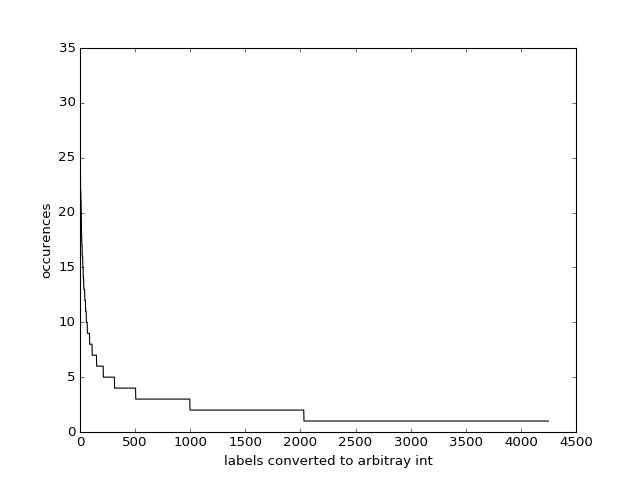

In [7]:
# Load the data and visualize it as a histogram
df = pandas.read_csv('./data/train.csv')
unique = pandas.value_counts(df.Id)
num_classes = unique.values.shape[0]
plt.figure()
plt.plot(range(1,num_classes),unique.values[1:],'-k')
plt.xlabel('labels converted to arbitray int')
plt.ylabel('occurences')
plt.show()

In [6]:
# How does the numer of categories compare to the number of training images?
print 'There are {:d} different labels and {:d} images in the training set'.\
    format(num_classes,df.shape[0])

There are 4251 different labels and 9850 images in the training set


In [8]:
# add an extra column which counts the number of occurences and sort by that column
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')
df = df.sort_values('occurrences',ascending=False)
df[:10]

,Image,Id,occurrences
1172,1e484732.jpg,new_whale,810
1230,200b53a2.jpg,new_whale,810
8688,e1eba938.jpg,new_whale,810
5080,842686a1.jpg,new_whale,810
5086,8441a59e.jpg,new_whale,810
5089,847238a3.jpg,new_whale,810
5105,84df4d6d.jpg,new_whale,810
5112,84eec364.jpg,new_whale,810
5119,8504db72.jpg,new_whale,810
5123,851a3114.jpg,new_whale,810


The label new_whale occurs 810 times. Let's see how many times the other labels occur. This is the same information that is displayed in the histogram above, but it is nice to have it as table as well.

In [9]:
# To do this I group by occurrences and then aggregate by the number of unique elements in that group
func = lambda x: len(set([element for element in x])) # set is used to only select unique elements
df.groupby('occurrences').aggregate(func)

,Image,Id
occurrences,,
1,2220,2220
2,2068,1034
3,1476,492
4,768,192
5,510,102
6,366,61
7,280,40
8,184,23
9,189,21


## In Summary

We have found that the distribution of the labels is highly skewed. In particular the label "new_whale" appears 810 times, while most labels appear only once. This makes identifying the whales with a challenging problem.

## What is the most common aspect ratio?

To feed the images to a neural network we need to resize them to a common size. In order to to this it is useful to first find the most common aspect ratio. Actually it turns out that the pretrained models expect the input images to be square with a minumum size of 224 x 224. However, it is still interesting to look at the distribution of aspect ratios

In [10]:
# find the most common aspect ratio
H = []
W = []
count = 0
folder = './data/train/'
t0 = time.time()
for fname in os.listdir(folder):
    if fname[-3:] == 'jpg':
        img = skimage.io.imread(folder+fname)
        H.append(img.shape[0])
        W.append(img.shape[1])
        count += 1
#     if count == 100:
#         break
t1 = time.time()

print 'Elapsed time: {:.4f}'.format(t1-t0)
H = np.array(H,dtype='float')
W = np.array(W,dtype='float')
A = H/W
unique, ret_counts = np.unique(A,return_counts=True)

Elapsed time: 113.1137


<IPython.core.display.Javascript object>


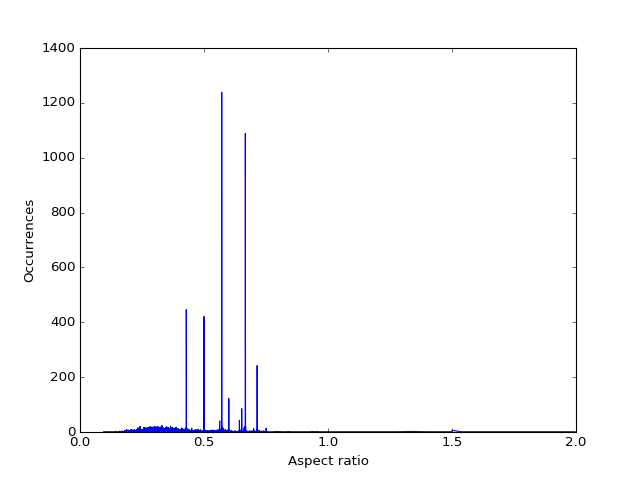

In [11]:
plt.figure()
plt.plot(unique,ret_counts)
plt.xlabel('Aspect ratio')
plt.ylabel('Occurrences')

The most common aspect ratios are: 9:16, and 2:3.

## Visualize the Whale Flukes

In [7]:
def imshow(image_tensor):
    # image_tensor is one of the image tensors from the training set.
    # If a Dataloader is used, use torchvision.utils.make_grid(image_tensor) first
    arr = image_tensor.numpy().transpose(1,2,0)
    arr = STD*arr + MEAN
    arr = np.clip(arr,0,1)
    plt.imshow(arr)

In [12]:
# Load the data into the WhaleDataset

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,int(224.0*16.0/9.0))),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ])

# Create a Dataloader and plot some images
data = WhaleDataset(df,'./data/',transform=transforms)
dataloader = torch.utils.data.DataLoader(data,\
                                            batch_size=4,\
                                            shuffle=True,\
                                            num_workers=4,\
                                            sampler=None)

<IPython.core.display.Javascript object>


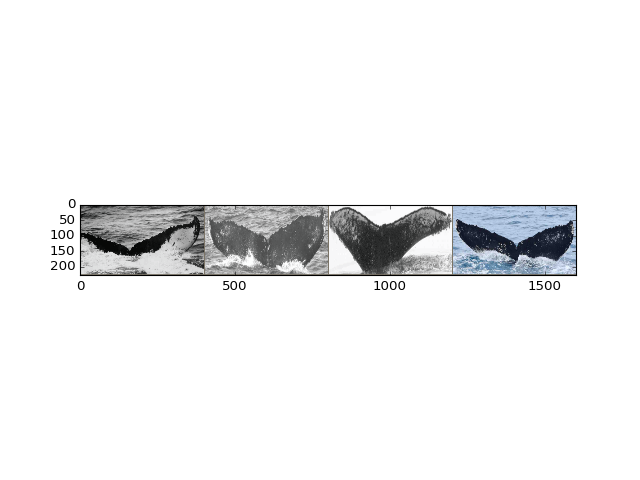

In [13]:
# Evaluate this cell to plot a new set of 4 random images
images, _ = next(iter(dataloader))
images = torchvision.utils.make_grid(images)
plt.figure()
imshow_tensor(images)

Note that most pictures show the whole fluke. It is therefore not advisable to crop them.